In [1]:
import torch

!nvidia-smi
!nvcc --version

torch.cuda.is_available()

Sat Mar 30 20:45:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4500               Off | 00000000:89:00.0 Off |                  Off |
| 30%   34C    P8              17W / 200W |      2MiB / 20470MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

In [5]:
!mamba install scikit-learn -y


Looking for: ['scikit-learn']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.10.*


Transaction

  Prefix: /net/galaxy/home/koes/vratins/miniforge3/envs/graph

  Updating specs:

   - scikit-learn
   - ca-certificates
   - certifi
   - openssl


  Package              Version  Build            Channel          Size
────────────────────────────────────────────────────────────────────────
  Install:
────────────────────────────────────────────────────────────────────────

  + joblib               1.3.2  pyhd8ed1ab_0     conda-forge     221kB
  + threadpoolctl        3.4.0  pyhc1e730c_0     conda-forge      23kB
  + scikit-learn   1.4.1.post1  py310h1fdf081_0  conda-forge       9MB

  Summary:

  Install: 3 packages

  Total download: 9MB

────────────────────────────────────────────────────────────────────────


[+] 0.0s
Extracting       ━━━━━━━━━━━━━━━━━━━━━━

In [14]:
import dgl
import dgl.function as fn
from torch import nn, einsum
import torch.nn as nn
import math

import torch.nn.functional as F

from typing import List, Tuple, Union, Dict

import sys
sys.path.append('/net/galaxy/home/koes/vratins/graphpocket/gnn')

from dataloader import get_dataloader, create_dataset
from graphpocket import GraphPocket

from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
import prody

prody.confProDy(verbosity='none')

In [26]:
#gvp

def exists(val):
    return val is not None

def _norm_no_nan(x, axis=-1, keepdims=False, eps=1e-8, sqrt=True):
    '''
    L2 norm of tensor clamped above a minimum value `eps`.
    
    :param sqrt: if `False`, returns the square of the L2 norm
    '''
    out = torch.clamp(torch.sum(torch.square(x), axis, keepdims), min=eps)
    return torch.sqrt(out) if sqrt else out

def _rbf(D, D_min=0., D_max=20., D_count=16):
    '''
    From https://github.com/jingraham/neurips19-graph-protein-design
    
    Returns an RBF embedding of `torch.Tensor` `D` along a new axis=-1.
    That is, if `D` has shape [...dims], then the returned tensor will have
    shape [...dims, D_count].
    '''
    device = D.device
    D_mu = torch.linspace(D_min, D_max, D_count, device=device)
    D_mu = D_mu.view([1, -1])
    D_sigma = (D_max - D_min) / D_count
    D_expand = torch.unsqueeze(D, -1)

    RBF = torch.exp(-((D_expand - D_mu) / D_sigma) ** 2)
    return RBF

class GVP(nn.Module):
    def __init__(
        self,
        dim_vectors_in,
        dim_vectors_out,
        dim_feats_in,
        dim_feats_out,
        hidden_vectors = None,
        feats_activation = nn.SiLU(),
        vectors_activation = nn.Sigmoid(),
        vector_gating = True,
        xavier_init = False
    ):
        super().__init__()
        self.dim_vectors_in = dim_vectors_in
        self.dim_feats_in = dim_feats_in

        self.dim_vectors_out = dim_vectors_out
        dim_h = max(dim_vectors_in, dim_vectors_out) if hidden_vectors is None else hidden_vectors

        # create Wh and Wu matricies
        wh_k = 1/math.sqrt(dim_vectors_in)
        wu_k = 1/math.sqrt(dim_h)
        self.Wh = torch.zeros(dim_vectors_in, dim_h, dtype=torch.float32).uniform_(-wh_k, wh_k)
        self.Wu = torch.zeros(dim_h, dim_vectors_out, dtype=torch.float32).uniform_(-wu_k, wu_k)
        self.Wh = nn.Parameter(self.Wh)
        self.Wu = nn.Parameter(self.Wu)

        self.vectors_activation = vectors_activation

        self.to_feats_out = nn.Sequential(
            nn.Linear(dim_h + dim_feats_in, dim_feats_out),
            feats_activation
        )

        # branching logic to use old GVP, or GVP with vector gating
        if vector_gating:
            self.scalar_to_vector_gates = nn.Linear(dim_feats_out, dim_vectors_out)
            if xavier_init:
                nn.init.xavier_uniform_(self.scalar_to_vector_gates.weight, gain=1)
                nn.init.constant_(self.scalar_to_vector_gates.bias, 0)
        else:
            self.scalar_to_vector_gates = None

    def forward(self, data):
        feats, vectors = data
        b, n, _, v, c  = *feats.shape, *vectors.shape

        assert c == 3 and v == self.dim_vectors_in, 'vectors have wrong dimensions'
        assert n == self.dim_feats_in, 'scalar features have wrong dimensions'

        Vh = einsum('b v c, v h -> b h c', vectors, self.Wh)
        Vu = einsum('b h c, h u -> b u c', Vh, self.Wu)

        sh = _norm_no_nan(Vh)

        s = torch.cat((feats, sh), dim = 1)

        feats_out = self.to_feats_out(s)

        if exists(self.scalar_to_vector_gates):
            gating = self.scalar_to_vector_gates(feats_out)
            gating = gating.unsqueeze(dim = -1)
        else:
            gating = _norm_no_nan(Vu)

        vectors_out = self.vectors_activation(gating) * Vu

        # if torch.isnan(feats_out).any() or torch.isnan(vectors_out).any():
        #     raise ValueError("NaNs in GVP forward pass")

        return (feats_out, vectors_out)
    
class _VDropout(nn.Module):
    '''
    Vector channel dropout where the elements of each
    vector channel are dropped together.
    '''
    def __init__(self, drop_rate):
        super(_VDropout, self).__init__()
        self.drop_rate = drop_rate
        self.dummy_param = nn.Parameter(torch.empty(0))

    def forward(self, x):
        '''
        :param x: `torch.Tensor` corresponding to vector channels
        '''
        device = self.dummy_param.device
        if not self.training:
            return x
        mask = torch.bernoulli(
            (1 - self.drop_rate) * torch.ones(x.shape[:-1], device=device)
        ).unsqueeze(-1)
        x = mask * x / (1 - self.drop_rate)
        return x
    
class GVPDropout(nn.Module):
    """ Separate dropout for scalars and vectors. """
    def __init__(self, rate):
        super().__init__()
        self.vector_dropout = _VDropout(rate)
        self.feat_dropout = nn.Dropout(rate)

    def forward(self, feats, vectors):
        return self.feat_dropout(feats), self.vector_dropout(vectors)


class GVPLayerNorm(nn.Module):
    """ Normal layer norm for scalars, nontrainable norm for vectors. """
    def __init__(self, feats_h_size, eps = 1e-5):
        super().__init__()
        self.eps = eps
        self.feat_norm = nn.LayerNorm(feats_h_size)

    def forward(self, feats, vectors):

        normed_feats = self.feat_norm(feats)

        vn = _norm_no_nan(vectors, axis=-1, keepdims=True, sqrt=False)
        vn = torch.sqrt(torch.mean(vn, dim=-2, keepdim=True) + self.eps ) + self.eps
        normed_vectors = vectors / vn
        return normed_feats, normed_vectors
    
#convolution
class GVPEdgeConv(nn.Module):

    def __init__(self, scalar_size: int = 128, vector_size: int = 16,
                  scalar_activation=nn.SiLU, vector_activation=nn.Sigmoid,
                  n_message_gvps: int = 1, n_update_gvps: int = 1,
                  rbf_dmax: float = 3.5, rbf_dim: int = 16,
                  edge_feat_size: int = 0, message_norm: Union[float, str] = 4, dropout: float = 0.0,):
        
        super().__init__()

        self.scalar_size = scalar_size
        self.vector_size = vector_size
        self.scalar_activation = scalar_activation
        self.vector_activation = vector_activation
        self.n_message_gvps = n_message_gvps
        self.n_update_gvps = n_update_gvps
        self.edge_feat_size = edge_feat_size
        self.rbf_dmax = rbf_dmax
        self.rbf_dim = rbf_dim
        self.dropout_rate = dropout
        self.message_norm = message_norm

        # create message passing function
        message_gvps = []
        for i in range(n_message_gvps):

            dim_vectors_in = vector_size
            dim_feats_in = scalar_size

            # on the first layer, there is an extra edge vector for the displacement vector between the two node positions
            if i == 0:
                dim_vectors_in += 1
                dim_feats_in += rbf_dim

            message_gvps.append(
                GVP(dim_vectors_in=dim_vectors_in, 
                    dim_vectors_out=vector_size, 
                    dim_feats_in=dim_feats_in, 
                    dim_feats_out=scalar_size, 
                    feats_activation=scalar_activation(), 
                    vectors_activation=vector_activation(), 
                    vector_gating=True)
            )
        self.edge_message = nn.Sequential(*message_gvps)

        # create update function
        update_gvps = []
        for i in range(n_update_gvps):
            update_gvps.append(
                GVP(dim_vectors_in=vector_size, 
                    dim_vectors_out=vector_size, 
                    dim_feats_in=scalar_size, 
                    dim_feats_out=scalar_size, 
                    feats_activation=scalar_activation(), 
                    vectors_activation=vector_activation(), 
                    vector_gating=True)
            )
        self.node_update = nn.Sequential(*update_gvps)

        
        self.dropout = GVPDropout(self.dropout_rate)
        self.message_layer_norm = GVPLayerNorm(self.scalar_size)
        self.update_layer_norm = GVPLayerNorm(self.scalar_size)

        if self.message_norm == 'mean':
            self.agg_func = fn.mean
        else:
            self.agg_func = fn.sum

    def forward(self, g: dgl.DGLHeteroGraph, 
                rec_feats: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], 
                edge_feats: torch.Tensor = None, 
                z: Union[float, torch.Tensor] = 1):
        # vec_feat has shape (n_nodes, n_vectors, 3)

        with g.local_scope():

            scalar_feat, coord_feat, vec_feat = rec_feats
            g.ndata["h"] = scalar_feat
            g.ndata["x"] = coord_feat
            g.ndata["v"] = vec_feat
            
            # edge feature
            if self.edge_feat_size > 0:
                assert edge_feats is not None, "Edge features must be provided."
                g.edata["a"] = edge_feats

            # get vectors between node positions
            g.apply_edges(fn.u_sub_v("x", "x", "x_diff"))

            # normalize x_diff and compute rbf embedding of edge distance
            # dij = torch.norm(g.edges[self.edge_type].data['x_diff'], dim=-1, keepdim=True)
            dij = _norm_no_nan(g.edata['x_diff'], keepdims=True) + 1e-8
            g.edata['x_diff'] = g.edata['x_diff'] / dij
            g.edata['d'] = _rbf(dij.squeeze(1), D_max=self.rbf_dmax, D_count=self.rbf_dim)

            # compute messages on every edge
            g.apply_edges(self.message)

            # aggregate messages from every edge
            g.update_all(fn.copy_e("scalar_msg", "m"), self.agg_func("m", "scalar_msg"))
            g.update_all(fn.copy_e("vec_msg", "m"), self.agg_func("m", "vec_msg"))


            # get aggregated scalar and vector messages
            scalar_msg = g.ndata["scalar_msg"] / z
            if isinstance(z, torch.Tensor):
                z = z.unsqueeze(-1)
            vec_msg = g.ndata["vec_msg"] / z

            # dropout scalar and vector messages
            scalar_msg, vec_msg = self.dropout(scalar_msg, vec_msg)

            # update scalar and vector features, apply layernorm
            scalar_feat = g.ndata['h'] + scalar_msg
            vec_feat = g.ndata['v'] + vec_msg
            scalar_feat, vec_feat = self.message_layer_norm(scalar_feat, vec_feat)

            # apply node update function, apply dropout to residuals, apply layernorm
            scalar_residual, vec_residual = self.node_update((scalar_feat, vec_feat))
            scalar_residual, vec_residual = self.dropout(scalar_residual, vec_residual)
            scalar_feat = scalar_feat + scalar_residual
            vec_feat = vec_feat + vec_residual
            scalar_feat, vec_feat = self.update_layer_norm(scalar_feat, vec_feat)

        return scalar_feat, vec_feat

    def message(self, edges):

        vec_feats = torch.cat([edges.data["x_diff"].unsqueeze(1), edges.src["v"]], dim=1)

        # create scalar features
        scalar_feats = [ edges.src['h'], edges.data['d'] ]

        # if self.edge_feat_size > 0:
        #     scalar_feats.append(edges.data['a'])

        scalar_feats = torch.cat(scalar_feats, dim=1)

        scalar_message, vector_message = self.edge_message((scalar_feats, vec_feats))

        return {"scalar_msg": scalar_message, "vec_msg": vector_message}

    
class ReceptorEncoderGVP(nn.Module):

    def __init__(self, 
                 in_scalar_size: int, 
                 out_scalar_size: int = 128, 
                 n_message_gvps: int = 1,
                 n_update_gvps: int = 1,
                 vector_size: int = 16,
                 n_convs: int = 3, 
                 message_norm: Union[float, str] = 10, 
                 dropout: float = 0.0,
                 rbf_dmax: float = 3.5):
        super().__init__()

        self.n_convs = n_convs
        self.in_scalar_size = in_scalar_size
        self.out_scalar_size = out_scalar_size
        self.vector_size = vector_size
        self.dropout_rate = dropout
        self.message_norm = message_norm
        self.rbf_dmax = rbf_dmax

        # check the message norm argument
        if isinstance(message_norm, str) and message_norm != 'mean':
            raise ValueError(f'message norm must be either a float, int, or "mean". Got {message_norm}')
        elif isinstance(message_norm, float) or isinstance(message_norm, int):
            pass
        elif not isinstance(message_norm, (str, float, int)):
            raise ValueError(f'message norm must be either a float, int, or "mean". Got {message_norm}')

        # create functions to embed scalar features to the desired size
        self.scalar_embed = nn.Sequential(
            nn.Linear(in_scalar_size, out_scalar_size),
            nn.SiLU(),
            nn.Linear(out_scalar_size, out_scalar_size),
            nn.SiLU()
        )
        self.scalar_norm = nn.LayerNorm(out_scalar_size)

        edge_feat_size = 1

        # create rec-rec convolutional layers
        self.rec_conv_layers = nn.ModuleList()
        for _ in range(n_convs):
            self.rec_conv_layers.append(GVPEdgeConv(
                scalar_size=out_scalar_size,
                vector_size=vector_size,
                n_message_gvps=n_message_gvps,
                n_update_gvps=n_update_gvps,
                edge_feat_size=edge_feat_size,
                dropout=dropout,
                message_norm=message_norm,
                rbf_dmax=rbf_dmax
            ))

    def forward(self, g: dgl.DGLHeteroGraph):

        device = g.device
        batch_size = g.batch_size

        # get scalar features
        rec_scalar_feat = g.ndata["h_0"]

        # embed scalar features
        rec_scalar_feat = self.scalar_embed(rec_scalar_feat)
        rec_scalar_feat = self.scalar_norm(rec_scalar_feat)

        # initialize receptor vector features
        rec_vec_feat = torch.zeros((g.num_nodes(), self.vector_size, 3), device=device)

        # get edge features
        edge_feat = g.edata['a']

        # get coordinate features
        rec_coord_feat = g.ndata['x_0']

        # compute the normalization factor for the messages if necessary
        if self.message_norm == 'mean':
            # set z to 1. the receptor convolutional layer will use mean aggregation instead of sum
            z = 1
        else:
            z = self.message_norm

        # apply receptor-receptor convolutions
        for i in range(self.n_convs):
            rec_feats = (rec_scalar_feat, rec_coord_feat, rec_vec_feat)
            rec_scalar_feat, rec_vec_feat = self.rec_conv_layers[i](g, rec_feats=rec_feats, edge_feats=edge_feat, z=z)

        vector_features_flattened = rec_vec_feat.view(rec_vec_feat.size(0), -1)  # Reshapes to [num_nodes, num_vectors * vector_dim]
    
        flattened_features = torch.cat([rec_scalar_feat, vector_features_flattened], dim=1)
        graph_descriptor = torch.mean(flattened_features, dim=0)

        return graph_descriptor
    


def con_loss(output1, output2, label, margin=1.0):
    euclidean_distance = F.pairwise_distance(output1, output2)    
    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                (label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss_contrastive

In [27]:
#setup

pocket_to_graph = GraphPocket()

g = pocket_to_graph(pocket_path='../../dataset_graph/data/11asA/11asA_pocket.pdb')
g = g.to(device)

model = ReceptorEncoderGVP(
    in_scalar_size=4,    #Matching the node_features dimension
    out_scalar_size=128,  #Desired output scalar size
    vector_size=16,       #Desired vector size
    n_convs=3,            #Number of convolution layers
    dropout=0.1           #Dropout rate
)
model = model.to(device)

updated_g = model(g)

print("Updated Features Shape:", updated_g.shape)

Updated Features Shape: torch.Size([176])


In [17]:
#dataloader
import time

start= time.time()

pos_path, neg_path = '../../dataset_graph/TOUGH-M1/TOUGH-M1_positive.list', '../../dataset_graph/TOUGH-M1/TOUGH-M1_negative.list'

train_dataset, test_dataset = create_dataset(pos_path, neg_path, fold_nr=0, type='seq')
train_dataloader = get_dataloader(train_dataset, batch_size=32, num_workers=4)

end = time.time()

print((end-start)/60.0)

3.057890597979228


In [ ]:
#train

epochs = 2
warmup_epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: min((epoch + 1) / warmup_epochs, 1))
epoch_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f'Epoch {epoch+1}/{epochs}')
    
    for batch_idx, ((graph1, graph2), label) in progress_bar:
        graph1, graph2, label = graph1.to(device), graph2.to(device), label.to(device)
        
        output1 = model(graph1)
        output2 = model(graph2)
        
        loss = con_loss(output1, output2, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        progress_bar.set_postfix({'Loss': running_loss/(batch_idx+1)})
        epoch_losses.append(running_loss)


Epoch 1/2:   3%|▎         | 755/22027 [01:07<30:36, 11.58it/s, Loss=0.351]

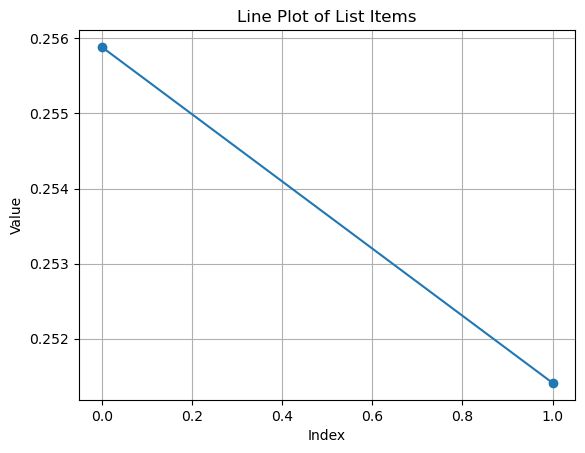

In [19]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses, marker='o')  # 'o' adds markers to each data point
plt.title('Line Plot of List Items')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()